# Uniformity on the 2D Plane

## -- really on the unit sphere
### 2019-09-21

This notebook contains just the SecondBestFriends algorithm.  See the "TracyPointDensity" notebook for the full
abeit meandering process that led to this algorithm.

I started with some basic geometric ideas inspired by Gauss that some sort of comparison of the perimeter and the area might give a useful metric.  I was able to pretty much prove that this is a bad approach.

I looked at the cummulative cross product of points on a unit sphere.  Regardless of orientation, the Nth root of the cummulative cross product (where N is the number of points) seems to give the geometric mean of the "spacing" of the points.  This is an interesting result that could be used as the input to a grid generator.  For instance the expectation for even spacing would be for 100 points to land in a grid that is 10X this provided distance.  One still has the problem of assiging a grid that actually gives this result.

Then I learned that a-priori methods of determining uniformity in dimensions > 1 are still a topic of research.  If you have a specific grid you want to check against (not really a-priori), you are good.  Otherwise not.  

As a way of avoiding the need for a pre-known grid or to generate a good one given an arbitrarily shaped set of points, I came up with the Convex Hull based HullPie algorithm.  

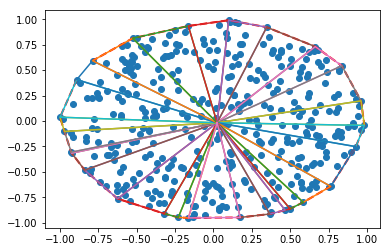

While debugging the HullPie code, I thought of the SecondBestFriends algorithm.  It seems to give the best results while not being as fast has HullPie.


Some papers:
* https://stats.stackexchange.com/questions/113464/understanding-scipy-kolmogorov-smirnov-test  -- speaks to useless of pvalue returned by kstest for uniform distribution.
* https://stackoverflow.com/questions/13005294/measure-the-uniformity-of-distribution-of-points-in-a-2d-square
* https://stats.stackexchange.com/questions/27288/two-dimensional-kolmogorov-smirnov
* http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1983MNRAS.202..615P&defaultprint=YES&filetype=.pdf
* http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1987MNRAS.225..155F&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf
* https://stats.stackexchange.com/questions/406406/test-of-uniform-distribution-using-ks-test-and-chi-square-in-r
* https://stats.stackexchange.com/questions/113464/understanding-scipy-kolmogorov-smirnov-test
* 


Coding references:
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
* https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m
* https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
* https://en.wikipedia.org/wiki/Shoelace_formula

In [1]:
import io, math, numpy, sys
import numpy as np
import scipy.optimize as opt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [2]:
## Configurable constants

# We generate this file in this notebook so that we can define our expected inputs.
TEST_DATA_FILE="tracy_test_data.tab"

In [3]:
## Constant Constants
AREA_EARTH_SQ_KM=510100000.0 # 510.1 million km²
RADIAN_2_KM=6371.0
SQ_RADIAN_2_SQ_KM=AREA_EARTH_SQ_KM/(4.0*math.pi)

In [4]:
# Unit sphere radian utility functions
def xyz2angles(xyz):
    lon_radians = numpy.arctan2(xyz[1], xyz[0])
    lat_radians = numpy.arcsin(xyz[2])
    return np.array([lat_radians, lon_radians])

def angles2xyz(latlon_radians):
    xyz = [math.cos(latlon_radians[0]) * math.cos(latlon_radians[1]), math.cos(latlon_radians[0]) * math.sin(latlon_radians[1]), math.sin(latlon_radians[0])]
    return np.array(xyz)


In [5]:
# Unit sphere lat lon utility functions
def degrees_to_radians(angle):
    rad = math.pi * angle / 180.0
    return rad
np_degrees_to_radians = np.vectorize(degrees_to_radians)

def radians_to_degrees(rad):
    deg = 180.0 * rad / math.pi
    return deg
np_radians_to_degrees = np.vectorize(radians_to_degrees)

def xyz2latlon(xyz):
    latlon_radians = xyz2angles(xyz)
    lat_deg = radians_to_degrees(latlon_radians[0])
    lon_deg = radians_to_degrees(latlon_radians[1])
    return np.array([lat_deg, lon_deg])
    
def latlon2xyz(latlon_deg):
    xyz = angles2xyz([degrees_to_radians(latlon_deg[0]), degrees_to_radians(latlon_deg[1])])
    return xyz


In [6]:
# Assuming real input will look like: <latitude>\t<longitude>\t<tag>

def genTestData():
    with open(TEST_DATA_FILE, "w+") as g:
        Box=[ (30.15, -97.83), (30.35, -97.62)]
        DotParams = {
            "LowerLeft-Coarse": [ (Box[0][0], (Box[0][0] + Box[1][0])/2, 0.05)
                                 , (Box[0][1], (Box[0][1] + Box[1][1])/2, 0.05)  ],
            "Box-Fine": [ (Box[0][0], Box[1][0], 0.01)
                                 , (Box[0][1], Box[1][1], 0.01)  ],
            "UpperRight-Medium": [ ((Box[0][0] + Box[1][0])/2, Box[1][0], 0.03)
                                 , ((Box[0][1] + Box[1][1])/2, Box[1][1], 0.03)  ]
        }
        for tag in DotParams:
            latRange = DotParams[tag][0]
            lonRange = DotParams[tag][1]
            for lat in np.arange(*latRange):
                for lon in np.arange(*lonRange):
                    line = '\t'.join([ str(lat), str(lon), tag ]) + '\n'
                    g.write(line)
#           

In [7]:
genTestData()

In [8]:
def loadData(tracyDataPath):
    data = {}
    with open(tracyDataPath, "r") as f:
        for line in f:
            line = line.rstrip()
            A = line.split('\t')
            if len(A)==3:
                (lat, lon, tag) = A
                if tag not in data:
                    data[tag] = []
                data[tag].append( np.array([lat, lon], dtype=float) )
    return data

In [9]:
testData = loadData(TEST_DATA_FILE)

In [10]:
# Second Best Friend (on unit sphere):
#  Finds the distance of the second-closest point for every point in the dataset
#  Slower than HullPies, but very consistent
#  Gives a direct measure of the "grid" spacing and the consistency of this spacing.
def secondBestFriendUS(XYZ):
    N = len(XYZ)
    # Space for distances to nearest and second-nearest neighbors
    secondBestFriendDist = np.zeros((N, 2))
    
    def dist(iPt, jPt):
        D = math.pi * (1.0 - np.dot(XYZ[iPt], XYZ[jPt]))
        return D

    for iPt in range(N):
        for jPt in range(iPt+1, N, 1):
            d = dist(iPt, jPt)
            if secondBestFriendDist[iPt][0] == 0.0:
                secondBestFriendDist[iPt,0] = d
            elif d < secondBestFriendDist[iPt,0]:
                secondBestFriendDist[iPt,1] = secondBestFriendDist[iPt,0]
                secondBestFriendDist[iPt,0] = d
            elif secondBestFriendDist[iPt][1] == 0.0:
                secondBestFriendDist[iPt,1] = d
            elif d < secondBestFriendDist[iPt,1]:
                secondBestFriendDist[iPt,1] = d

            if secondBestFriendDist[jPt][0] == 0.0:
                secondBestFriendDist[jPt,0] = d
            elif d < secondBestFriendDist[jPt,0]:
                secondBestFriendDist[jPt,1] = secondBestFriendDist[jPt,0]
                secondBestFriendDist[jPt,0] = d
            elif secondBestFriendDist[jPt][1] == 0.0:
                secondBestFriendDist[jPt,1] = d
            elif d < secondBestFriendDist[jPt,1]:
                secondBestFriendDist[jPt,1] = d
    #

    sbfMin = min(secondBestFriendDist[: ,1])
    sbfAvg = np.sum(secondBestFriendDist[: ,1], axis=0)/N
    sbfMax = max(secondBestFriendDist[: ,1])
    sbfStdD = np.std((secondBestFriendDist[: ,1]-sbfMin)/(sbfAvg-sbfMin))
    sbfMedian = np.median(secondBestFriendDist[: ,1], axis=0)
    
    return sbfAvg, sbfStdD, (sbfMin, sbfMedian, sbfMax)
#

def secondBestFriendLatLon(LATLON):
    N = len(LATLON)
    XYZ = [ latlon2xyz(LATLON[i]) for i in range(N) ]
    sbfAvg, sbfStdD, (sbfMin, sbfMedian, sbfMax) =  secondBestFriendUS(XYZ)
    # convert radian distances to kilometers (everything but normalized StdDev)
    sbfAvg = sbfAvg * RADIAN_2_KM
    sbfMin = sbfMin * RADIAN_2_KM
    sbfMedian = sbfMedian * RADIAN_2_KM
    sbfMax = sbfMax * RADIAN_2_KM
    return sbfAvg, sbfStdD, (sbfMin, sbfMedian, sbfMax)
    

In [11]:
# Note the test grid data is laid out in perfect increments of lat and lon near Austin. 
# So the lon distances are really half the lat distances leading to non-uniformity. 
def testSecondBestFriendLatLon():
    for tag in testData:
        print([tag, secondBestFriendLatLon(testData[tag])])
testSecondBestFriendLatLon()

['LowerLeft-Coarse', (0.006978385677687368, 0.7039429918813392, (0.005687014027218069, 0.00762117963721896, 0.0076211796394410804))]
['Box-Fine', (0.0002348486740235625, 2.9000441891427475, (0.00022701703873227212, 0.00022752688217911958, 0.00030484720744331406))]
['UpperRight-Medium', (0.002394536570253434, 0.9946544468126709, (0.002043570854020428, 0.002395474953905481, 0.002743624780327107))]
